In [6]:
!pip3 install numpy
!pip3 install pandas
!pip3 install torch
!pip3 install scikit-learn
!pip3 install matplotlib



[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached pandas-2.2.3-cp310-cp310-macosx_11_0_arm64.whl (11.3 MB)
  Using cached tzdata-2024.2-py2.py3-none-any.whl (346 kB)
  Using cached pytz-2024.2-py2.py3-none-any.whl (508 kB)

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Using cached torch-2.5.1-cp310-none-macosx_11_0_arm64.whl (63.9 MB)
  Using cached fsspec-2024.10.0-py3-none-any.whl (179 kB)
  Using cached filelock-3.16.1-py3-none-any.whl (16 kB)
  Using cached sympy-1.13.1-py3-none-any.whl (6.2 MB)
  Using cached jinja2-3.1.4-py3-none-any.whl (133 kB)
  Using cached networkx-3.4.2-py3-none-any.whl (1.7 MB)
  Using cached mpmath-1.3.0-py3-none-any.whl (536 kB)
  Using cached MarkupSafe-3.0.2-cp310-cp310-macosx_11_0_arm64.whl (12 kB)

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip
  Usin

In [318]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt


In [319]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

In [313]:

class TurbofanDataset(Dataset):
    def __init__(self, data, sequence_length=50):
        self.sequence_length = sequence_length

        # Extract features (sensor measurements and operational settings)
        self.features = data[:, 2:26].astype(float)  # columns 3-26

        # Calculate RUL for training data
        max_cycles = pd.DataFrame(data[:, :2].astype(int)).groupby(0)[1].max()
        rul = (
            pd.DataFrame(data[:, :2].astype(int))
            .groupby(0)[1]
            .transform(lambda x: max_cycles[x.name] - x)
        )
        self.targets = rul.values.reshape(-1, 1)

        # Normalize features
        self.scaler = StandardScaler()
        self.features = self.scaler.fit_transform(self.features)

        # Prepare sequences
        self.prepare_sequences()

    def prepare_sequences(self):
        # Group by engine unit
        df = pd.DataFrame(np.hstack((self.features, self.targets)))
        engine_groups = df.groupby(df.index // self.sequence_length)

        sequences = []
        targets = []

        for _, group in engine_groups:
            if len(group) >= self.sequence_length:
                sequences.append(group.iloc[: self.sequence_length, :-1].values)
                targets.append(group.iloc[self.sequence_length - 1, -1])

        self.sequences = torch.FloatTensor(np.array(sequences))
        self.targets = torch.FloatTensor(np.array(targets))

    def __len__(self):
        return len(self.sequences)

    def __getitem__(self, idx):
        return self.sequences[idx], self.targets[idx]

In [314]:
class Predictor(nn.Module):
    def __init__(self, input_size=24):
        super(Predictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [315]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for sequences, targets in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


In [316]:
def evaluate_model(model, test_loader, device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)



## Single node trainin

### Single node with FD001

In [325]:
# Load data
train_data = np.loadtxt("./CMAPSSData/train_FD001.txt")
test_data = np.loadtxt("./CMAPSSData/test_FD001.txt")

# Create datasets
train_dataset = TurbofanDataset(train_data)
test_dataset = TurbofanDataset(test_data)

In [333]:
single_model = Predictor().to(device)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

optimizer = torch.optim.Adam(single_model.parameters())
criterion = nn.MSELoss()
single_losses = []

for epoch in range(10):
    train_loss = train_model(
        single_model, train_loader, criterion, optimizer, device
    )
    test_loss = evaluate_model(single_model, test_loader, device)
    single_losses.append(test_loss)
    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")

Epoch 1, Test Loss: 9156.0825
Epoch 2, Test Loss: 9138.3514
Epoch 3, Test Loss: 9107.9464
Epoch 4, Test Loss: 9049.2185
Epoch 5, Test Loss: 8934.2520
Epoch 6, Test Loss: 8709.6241
Epoch 7, Test Loss: 8308.5934
Epoch 8, Test Loss: 7664.1008
Epoch 9, Test Loss: 6765.8792
Epoch 10, Test Loss: 5696.5160


Text(0.5, 1.0, 'Model Performance Comparison')

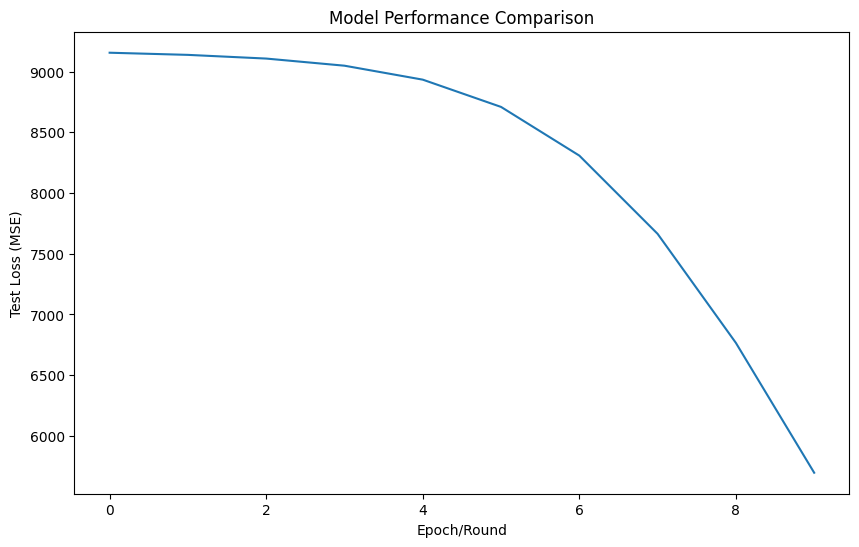

In [334]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(single_losses, label="Single Node")
plt.xlabel("Epoch/Round")
plt.ylabel("Test Loss (MSE)")
plt.title("Model Performance Comparison")

### Single node with FD001 and FD002

In [330]:
train_dataset = TurbofanDataset(np.loadtxt("./CMAPSSData/train_FD001.txt"))
len(train_dataset)

412

In [335]:
train_data_001 = np.loadtxt("./CMAPSSData/train_FD001.txt")
train_data_002 = np.loadtxt("./CMAPSSData/train_FD002.txt")
test_data = np.loadtxt("./CMAPSSData/test_FD001.txt")

In [336]:
train_data_combined = np.vstack((train_data_001, train_data_002))

In [337]:
len(train_data_combined)

74390

In [46]:
train_dataset = TurbofanDataset(train_data_combined)
test_dataset = TurbofanDataset(test_data)

In [47]:
print(f"Training dataset size: {len(train_dataset)} sequences")
print(f"Test dataset size: {len(test_dataset)} sequences")

Training dataset size: 1487 sequences
Test dataset size: 261 sequences


In [48]:
single_model = Predictor().to(device)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [338]:
len(train_loader)

13

In [49]:
optimizer = torch.optim.Adam(single_model.parameters())
criterion = nn.MSELoss()
single_losses = []

for epoch in range(10):
    train_loss = train_model(
        single_model, train_loader, criterion, optimizer, device
    )
    test_loss = evaluate_model(single_model, test_loader, device)
    single_losses.append(test_loss)
    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")

/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([15])) that is different to the input size (torch.Size([15, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 50, 1])). This will likely lead to incorre

Epoch 1, Test Loss: 9097.9036
Epoch 2, Test Loss: 8463.8148
Epoch 3, Test Loss: 6008.2806
Epoch 4, Test Loss: 5800.1673
Epoch 5, Test Loss: 5626.7356
Epoch 6, Test Loss: 5497.4736
Epoch 7, Test Loss: 5322.6119
Epoch 8, Test Loss: 5312.8855
Epoch 9, Test Loss: 5243.6541
Epoch 10, Test Loss: 5273.1433


Text(0.5, 1.0, 'Model Performance Comparison')

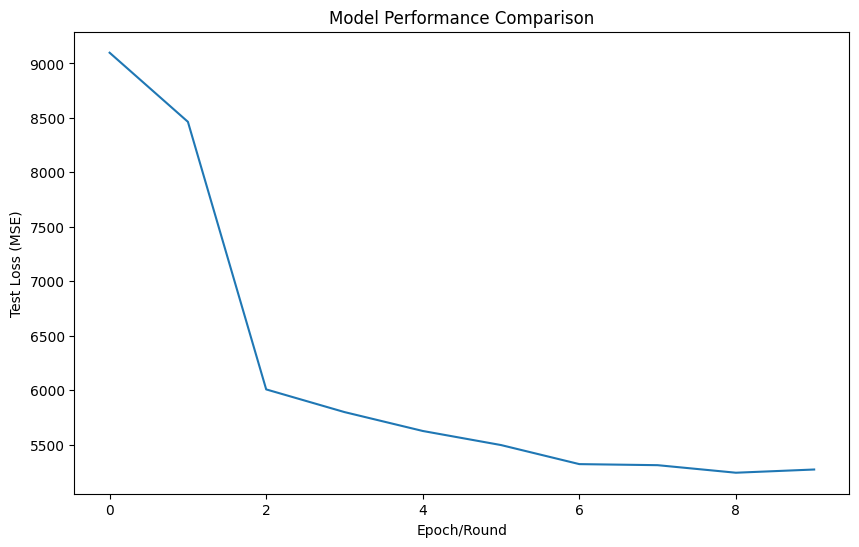

In [50]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(single_losses, label="Single Node")
plt.xlabel("Epoch/Round")
plt.ylabel("Test Loss (MSE)")
plt.title("Model Performance Comparison")

### Single node with FD001, 002, 003 and 004

In [59]:
train_data_001 = np.loadtxt("./CMAPSSData/The experimental results demonstrate that the federated learning approach achieved comparable model accuracy to the centralized single-node implementation, despite each participant utilizing only a fraction of the total dataset. This finding is particularly significant as it highlights the efficiency of federated learning in scenarios where data is distributed across multiple entities. The approach proves especially valuable for organizations or institutions that individually possess limited datasets but seek to develop robust models with high performance characteristics. Furthermore, federated learning's inherent privacy-preserving mechanism addresses critical data security concerns, as participants can contribute to model development without sharing their raw data. This makes it an ideal solution for sensitive industries such as healthcare, finance, or industrial applications where data privacy regulations or competitive advantages necessitate strict data protection while still enabling collaborative model improvement. The successful implementation demonstrates that federated learning effectively bridges the gap between data privacy requirements and the need for large-scale machine learning model training..txt")
train_data_002 = np.loadtxt("./CMAPSSData/train_FD002.txt")
train_data_003 = np.loadtxt("./CMAPSSData/train_FD003.txt")
test_data = np.loadtxt("./CMAPSSData/test_FD001.txt")

In [60]:
train_data_combined = np.vstack((train_data_001, train_data_002, train_data_003))

In [61]:
train_dataset = TurbofanDataset(train_data_combined)
test_dataset = TurbofanDataset(test_data)

In [62]:
print(f"Training dataset size: {len(train_dataset)} sequences")
print(f"Test dataset size: {len(test_dataset)} sequences")

Training dataset size: 1982 sequences
Test dataset size: 261 sequences


In [63]:
single_model = Predictor().to(device)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32)

In [64]:
optimizer = torch.optim.Adam(single_model.parameters())
criterion = nn.MSELoss()
single_losses = []

for epoch in range(10):
    train_loss = train_model(
        single_model, train_loader, criterion, optimizer, device
    )
    test_loss = evaluate_model(single_model, test_loader, device)
    single_losses.append(test_loss)
    print(f"Epoch {epoch+1}, Test Loss: {test_loss:.4f}")

/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([30])) that is different to the input size (torch.Size([30, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 50, 1])). This will likely lead to incorre

Epoch 1, Test Loss: 8980.6023
Epoch 2, Test Loss: 7241.8624
Epoch 3, Test Loss: 5564.7167
Epoch 4, Test Loss: 5460.4392
Epoch 5, Test Loss: 5222.3516
Epoch 6, Test Loss: 5132.5300
Epoch 7, Test Loss: 4981.5414
Epoch 8, Test Loss: 4920.5113
Epoch 9, Test Loss: 4853.5980
Epoch 10, Test Loss: 4897.9817


Text(0.5, 1.0, 'Model Performance Comparison')

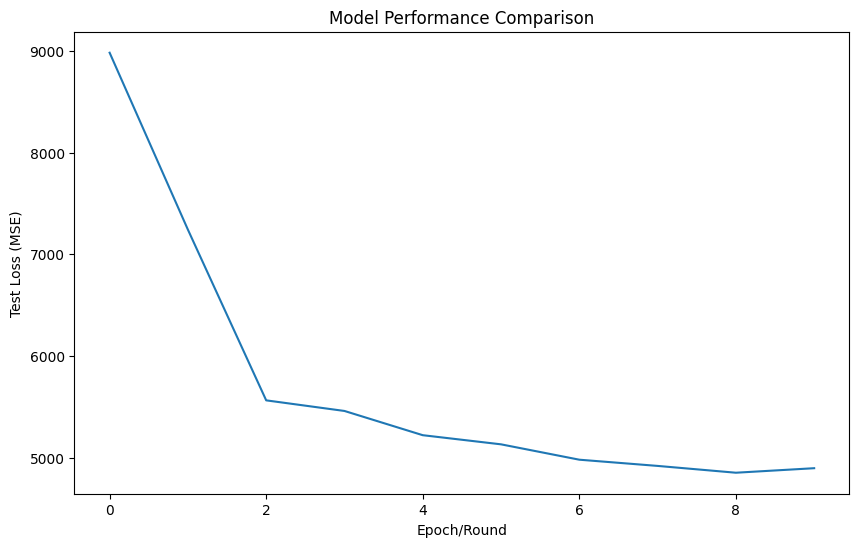

In [65]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(single_losses, label="Single Node")
plt.xlabel("Epoch/Round")
plt.ylabel("Test Loss (MSE)")
plt.title("Model Performance Comparison")

## Federated learning with 3 participants

In [82]:
!pip3 install lightphe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.5/53.5 kB 1.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 297.0/297.0 kB 7.1 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 5.7/5.7 MB 6.6 MB/s eta 0:00:00a 0:00:01
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 kB 7.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.0/63.0 kB 5.5 MB/s eta 0:00:00
  Attempting uninstall: sympy
    Found existing installation: sympy 1.13.1
    Uninstalling sympy-1.13.1:
      Successfully uninstalled sympy-1.13.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torch 2.5.1 requires sympy==1.13.1; python_version >= "3.9", but you have sympy 1.12 which is incompatible.

[notice] A new release of pip available: 22.3.1 -> 24.3.1
[notice] To update, run: pip install --upgrade pip


In [71]:
import subprocess
import json

In [68]:
train_data = np.loadtxt("./CMAPSSData/train_FD001.txt")
test_data = np.loadtxt("./CMAPSSData/test_FD001.txt")

# Create datasets
train_dataset = TurbofanDataset(train_data)
test_dataset = TurbofanDataset(test_data)

In [69]:
def federated_training(
    models, train_loaders, test_loader, num_rounds=10, device="cuda"
):
    losses = []

    for round in range(num_rounds):
        # Local training
        local_weights = []
        for i in range(len(models)):
            optimizer = torch.optim.Adam(models[i].parameters())
            criterion = nn.MSELoss()
            train_loss = train_model(
                models[i], train_loaders[i], criterion, optimizer, device
            )
            local_weights.append([param.data for param in models[i].parameters()])

        # Aggregate weights (FedAvg)
        averaged_weights = []
        for param_idx in range(len(local_weights[0])):
            averaged_weights.append(
                sum(weights[param_idx] for weights in local_weights)
                / len(local_weights)
            )

        # Update all models with averaged weights
        for model in models:
            for param, avg_weight in zip(model.parameters(), averaged_weights):
                param.data = avg_weight.clone()

        # Evaluate
        test_loss = evaluate_model(models[0], test_loader, device)
        losses.append(test_loss)
        print(f"Round {round+1}, Test Loss: {test_loss:.4f}")

    return losses



In [70]:
print("\nFederated Training (3 participants):")
num_participants = 3
fed_models = [Predictor().to(device) for _ in range(num_participants)]

# Split dataset among participants
dataset_splits = np.array_split(range(len(train_dataset)), num_participants)
fed_datasets = [
    torch.utils.data.Subset(train_dataset, indices) for indices in dataset_splits
]
fed_loaders = [DataLoader(ds, batch_size=32, shuffle=True) for ds in fed_datasets]

fed_losses_3 = federated_training(
    fed_models, fed_loaders, test_loader, device=device
)



Federated Training (3 participants):
Round 1, Test Loss: 9177.8728
Round 2, Test Loss: 9174.3020
Round 3, Test Loss: 9170.3661
Round 4, Test Loss: 9165.4908
Round 5, Test Loss: 9159.4115
Round 6, Test Loss: 9151.9099


/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 50, 1])). This will likely lead to incorre

Round 7, Test Loss: 9142.4963
Round 8, Test Loss: 9130.5224
Round 9, Test Loss: 9115.3842
Round 10, Test Loss: 9096.2676


In [307]:
from phe import LightPHE, encrypt_array, decrypt_array, homomorphic_addition

In [308]:
def train_model(model, train_loader, criterion, optimizer, device):
    model.train()
    total_loss = 0
    for sequences, targets in train_loader:
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)


In [309]:
def evaluate_model(model, test_loader, device):
    model.eval()
    criterion = nn.MSELoss()
    total_loss = 0
    with torch.no_grad():
        for sequences, targets in test_loader:
            sequences, targets = sequences.to(device), targets.to(device)
            outputs = model(sequences)
            loss = criterion(outputs, targets)
            total_loss += loss.item()
    return total_loss / len(test_loader)



In [310]:
def secure_federated_training(
    models, train_loaders, test_loader, local_epochs=10, num_rounds=10, device="cuda"
):
    losses = []
    BASIS_POINT = 1000
    OFFSET = 10     # Offset to handle negative numbers
    
    # Generate keypair for homomorphic encryption
    cs = LightPHE(algorithm_name="Paillier")

    for round in range(num_rounds):
        print(f"\nFederated Round {round+1}/{num_rounds}")
        encrypted_tensors = []
        
        for i in range(len(models)):
            optimizer = torch.optim.Adam(models[i].parameters())
            criterion = nn.MSELoss()
            
            print(f"\nParticipant {i+1} local training:")
            for epoch in range(local_epochs):
                train_loss = train_model(
                    models[i], train_loaders[i], criterion, optimizer, device
                )
                if (epoch + 1) % 2 == 0:
                    print(f"Local Epoch {epoch+1}/{local_epochs}, Loss: {train_loss:.4f}")
            
            # Collect and scale up parameters
            all_weights = []
            for param in models[i].parameters():
                weights = param.data.cpu().numpy().flatten()
                # Add offset and scale
                weights = ((weights + OFFSET) * BASIS_POINT).astype(int)
                all_weights.extend(weights.tolist())
            
            # Encrypt weights directly using LightPHE
            encrypted_tensor = cs.encrypt(all_weights)
            encrypted_tensors.append(encrypted_tensor)

        # Secure aggregation using homomorphic addition
        print("\nPerforming secure aggregation...")
        aggregated_weights = encrypted_tensors[0]
        for encrypted_tensor in encrypted_tensors[1:]:
            aggregated_weights = aggregated_weights + encrypted_tensor
        
        # Apply scaling factor for averaging
        num_participants = len(models)
        scaling_factor = int((1.0 / num_participants) * BASIS_POINT)
        averaged_weights = aggregated_weights * scaling_factor
        
        # Decrypt and process
        decrypted_weights = cs.decrypt(averaged_weights)
        
        # Scale back down and remove offset
        all_weights = np.array([
            (float(x) / (BASIS_POINT * BASIS_POINT)) - OFFSET  # Double BASIS_POINT due to averaging
            for x in decrypted_weights
        ])
        
        print(f"Sample weights after decryption: {all_weights[:5]}")
        
        # Split weights back into parameter shapes
        start_idx = 0
        averaged_weights = []
        for param in models[0].parameters():
            param_size = np.prod(param.shape)
            param_weights = all_weights[start_idx:start_idx + param_size]
            averaged_weights.append(
                torch.tensor(
                    param_weights.reshape(param.shape),
                    dtype=torch.float32
                ).to(device)
            )
            start_idx += param_size

        # Update all models with averaged weights
        for model in models:
            for param, avg_weight in zip(model.parameters(), averaged_weights):
                param.data = avg_weight.clone()

        # Evaluate global model
        test_loss = evaluate_model(models[0], test_loader, device)
        losses.append(test_loss)
        print(f"Round {round+1} completed, Global Test Loss: {test_loss:.4f}")

    return losses

In [311]:
class Predictor(nn.Module):
    def __init__(self, input_size=24):
        super(Predictor, self).__init__()
        self.layers = nn.Sequential(
            nn.Linear(input_size, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, 24),
            nn.ReLU(),
            nn.Linear(24, 1),
        )

    def forward(self, x):
        return self.layers(x)

In [312]:
# Use the secure federated training instead of the original one
print("\nFederated Training (3 participants):")
num_participants = 3
fed_models = [Predictor().to(device) for _ in range(num_participants)]

train_data = np.loadtxt("./CMAPSSData/train_FD001.txt")
test_data = np.loadtxt("./CMAPSSData/test_FD001.txt")

# Create datasets
train_dataset = TurbofanDataset(train_data)
test_dataset = TurbofanDataset(test_data)

test_loader = DataLoader(test_dataset, batch_size=32)

# Split dataset among participants
dataset_splits = np.array_split(range(len(train_dataset)), num_participants)
fed_datasets = [
    torch.utils.data.Subset(train_dataset, indices) for indices in dataset_splits
]
fed_loaders = [DataLoader(ds, batch_size=32, shuffle=True) for ds in fed_datasets]


fed_losses_3 = secure_federated_training(
    fed_models, 
    fed_loaders, 
    test_loader, 
    local_epochs=10,  # Each participant trains for 10 epochs
    num_rounds=10,    # 10 rounds of federation
    device=device
)


Federated Training (3 participants):

Federated Round 1/10

Participant 1 local training:
Local Epoch 2/10, Loss: 14055.5490
Local Epoch 4/10, Loss: 14576.5691
Local Epoch 6/10, Loss: 13719.8439
Local Epoch 8/10, Loss: 13669.6174
Local Epoch 10/10, Loss: 15093.5172


/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([32])) that is different to the input size (torch.Size([32, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)
/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([10])) that is different to the input size (torch.Size([10, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Participant 2 local training:
Local Epoch 2/10, Loss: 16581.3273
Local Epoch 4/10, Loss: 19898.8633
Local Epoch 6/10, Loss: 18208.7699
Local Epoch 8/10, Loss: 16754.1508
Local Epoch 10/10, Loss: 17080.5256


/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([9])) that is different to the input size (torch.Size([9, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Participant 3 local training:
Local Epoch 2/10, Loss: 18673.4461
Local Epoch 4/10, Loss: 18591.5512
Local Epoch 6/10, Loss: 16066.0653
Local Epoch 8/10, Loss: 17652.9764
Local Epoch 10/10, Loss: 16895.6822

Performing secure aggregation...
Sample weights after decryption: [-0.050293 -0.020656  0.074915 -0.033643  0.034622]
Round 1 completed, Global Test Loss: 9137.7035

Federated Round 2/10

Participant 1 local training:
Local Epoch 2/10, Loss: 14455.1486
Local Epoch 4/10, Loss: 13222.0943
Local Epoch 6/10, Loss: 14285.1086
Local Epoch 8/10, Loss: 15157.1277
Local Epoch 10/10, Loss: 13539.5836


/Users/ngjupeng/.pyenv/versions/3.10.10/lib/python3.10/site-packages/torch/nn/modules/loss.py:608: UserWarning: Using a target size (torch.Size([5])) that is different to the input size (torch.Size([5, 50, 1])). This will likely lead to incorrect results due to broadcasting. Please ensure they have the same size.
  return F.mse_loss(input, target, reduction=self.reduction)



Participant 2 local training:
Local Epoch 2/10, Loss: 16494.1916
Local Epoch 4/10, Loss: 17013.9824
Local Epoch 6/10, Loss: 16497.1969
Local Epoch 8/10, Loss: 16917.5738
Local Epoch 10/10, Loss: 15497.9094

Participant 3 local training:
Local Epoch 2/10, Loss: 17560.2547
Local Epoch 4/10, Loss: 17783.7779
Local Epoch 6/10, Loss: 18545.2697
Local Epoch 8/10, Loss: 17525.0803
Local Epoch 10/10, Loss: 16465.6711

Performing secure aggregation...
Sample weights after decryption: [-0.112231 -0.062614  0.063926 -0.041968  0.082907]
Round 2 completed, Global Test Loss: 8857.2386

Federated Round 3/10

Participant 1 local training:
Local Epoch 2/10, Loss: 14621.0975
Local Epoch 4/10, Loss: 15202.9568
Local Epoch 6/10, Loss: 13155.3453
Local Epoch 8/10, Loss: 13267.5011
Local Epoch 10/10, Loss: 12268.0119

Participant 2 local training:
Local Epoch 2/10, Loss: 17024.4320
Local Epoch 4/10, Loss: 17066.1703
Local Epoch 6/10, Loss: 15401.1566
Local Epoch 8/10, Loss: 15275.6217
Local Epoch 10/10, L

In [ ]:
from phe import LightPHE, encrypt_array, decrypt_array, homomorphic_addition

Text(0.5, 1.0, 'Model Performance Comparison')

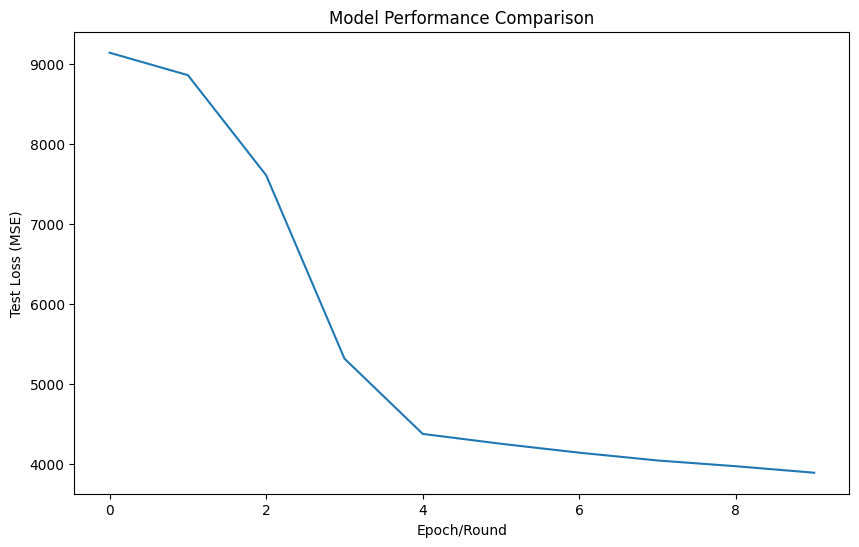

In [323]:
# Plot results
plt.figure(figsize=(10, 6))
plt.plot(fed_losses_3, label="Single Node")
plt.xlabel("Epoch/Round")
plt.ylabel("Test Loss (MSE)")
plt.title("Model Performance Comparison")

In [324]:
fed_losses_3

[9137.703504774305,
 8857.238552517361,
 7605.839463975694,
 5314.986300998264,
 4373.938395182292,
 4250.926052517361,
 4139.429660373264,
 4041.992431640625,
 3970.2989637586807,
 3889.122314453125]